**Intervalo de Confiança - COVID 19**

Fonte do intervalo de confiança: https://towardsdatascience.com/get-confidence-intervals-for-any-model-performance-metrics-in-machine-learning-f9e72a3becb2

The percentile bootstrap methodology for estimating the confidence interval is as follows:

1- Generate nboots “bootstrap sample” datasets, each the same size as the original test set. Each sample dataset is obtained by drawing instances at random from the test set with replacement.

2- On each of the sample datasets, calculate the metric and save it.

3- The 95% confidence interval is given by the 2.5th to the 97.5th percentile among the nboots calculated values of the metric. If nboots=1001 and you sorted the values in a series/array/list X of length 1001, the 0th percentile is X[0] and the 100th percentile is X[1000], so the confidence interval would be given by X[25] to X[975].

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_excel('Planilha COVID-19 completa.xlsx', header=1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dataset.replace(99999, np.nan, inplace = True)
dataset.replace(99999.0, np.nan, inplace = True)
teste = (dataset.isnull().sum()/dataset.shape[0]) * 100
teste1 = pd.DataFrame(teste,columns=list('A'))
teste1.reset_index(level=0, inplace=True)
teste1 = teste1.rename(columns={'index':'Campos','A': 'Valores'})
teste1.loc[teste1['Valores']>30]
teste1.drop(teste1.loc[teste1['Valores']<30].index, inplace=True)
for ind in teste1.index:
  dataset = dataset.drop(teste1['Campos'][ind], axis=1)
dataset.dropna(inplace=True)
dataset.describe().round(2)
dataset.corr().round(2)
dataset2 = pd.DataFrame(dataset)
dataset2.to_csv('nome_do_arquivo.csv')
dataset3 = pd.read_csv('nome_do_arquivo.csv',encoding='utf-8')

#MELHORAR MODELO= MELHORAR QUALIDADE DOS DADOS = REMOVER COLUNAS QUE CLARAMENTE NAO TEM CONTRIBUIÇÃO DIRETA (EXEMPLO: DATAS)

dataset3 = dataset3[[

 'Classif. OMS modif.',
 'Classif. NIH',
 'Classif. Guideline (7th ed.)',
 'Idade (anos)',
 'Sexo',
 'Tempo de Internação (dias)',
 'Semana Epidemiológica',
 'Febre',
 'Dor de garganta',
 'Tosse seca',
 'Tosse produtiva',
 'Dispnéia / Desconforto respiratório',
 'Astenia',
 'Cefaleia',
 'Saturação de O2 <95',
 'Mal estar geral',
 'Dor em articulações',
 'Dor muscular',
 'Dor abdominal',
 'Diarreia',
 'Vômitos',
 'Alteração do olfato e do paladar',
 'Coriza / Congestão Nasal',
 'Aperto torácico',
 'Dor no corpo',
 'Nauseas',
 'D1',
 'DATA D1',
 'Síndrome de Down',
 'Diabetes',
 'HAS',
 'HIV',
 'Doença cardíaca crônica',
 'Doença hepática crônica',
 'Doença renal crônica',
 'Doença hematológica crônica',
 'Neoplasia',
 'Pneumopatia crônica',
 'Asma',
 'DPOC',
 'Bronquiectasia',
 'DPID',
 'Tuberculose',
 'Doença reumatológica',
 'Obesidade',
 'Uso de imunossupressor',
 'Doença congênita',
 'Desnutrição',
 'Temp. máx (°C)',
 'Pressão SISTOLICA + baixa ',
 'Pressão DIASTOLICA + baixa',
 'F.R mais alta',
 'F.C mais alta',
 'Saturação O2 mais baixa',
 'Suplementação de O2',
 'Suporte ventilatório',
 'Medicação vasopressora',
 'Diálise/hemodiálise',
 'Parada cardiorespiratório',
 'Sepsis',
 'Choque',
 'Falência miocárdica',
 'Infarto miocárdio',
 'Insuficiência renal',
 'Glicemia (HGT)',
 'Leucócitos totais (/μL)',
 ' Plaquetas',
 'TGP',
 'Creatinina',
 'Proteína C reativa (mg/L)',
 'UREIA (mg/dL)',
 'Antibiótico',
 'Antiviral (Oseltamivir)',
 'Anticoagulante (Enoxaparina ou Análogo)',
 'Broncodilatador',
 'Cloroquina / Hidroxicloroquina',
 'Corticoterapia',
 'SRAG',
 'Desfecho',
 'internação - desfecho',
 'Classif. OMS']]

In [3]:
#Features/Previsores e a Target/Classe
previsores = dataset3.iloc[:, 0:80].values # da primeira coluna a penultima
classe     = dataset3.iloc[:,80].values # Coluna Classif OMS

# Nota: como o "banco de dados tratado" tem entradas não numéricas, usei o get_dummies conforme orientação Prof. Erico.
previsores = pd.DataFrame(previsores)

# remover uma das colunas para evitar dependencia linear
previsores = pd.get_dummies(previsores, drop_first=True)


In [4]:
#Normalização dos Dados
#evita que algumas variáveis tenham maior influência no modelo devido a diferenças de escala

# depois da divisão
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
previsores = scaler.fit_transform(previsores) # apenas no conjunto de previsores_treinamento

#MELHORAR MODELO= MELHORAR QUALIDADE DOS DADOS = REMOVER OUTLIERS ((valores atípicos ou extremos))

#Este método limita os valores a um intervalo determinado, entre -1 e 1. 
#Assim, valores fora deste intervalo são "clipeados" e convertidos para máximo/mínimo permitido
previsores_outlier = previsores.clip(-1,1)
previsores = previsores_outlier

In [5]:
#Divisão 70% Treino | 30% Teste
from sklearn.model_selection import train_test_split
previsores_treinamento, previsores_teste, classe_treinamento, classe_teste = train_test_split(previsores,classe,test_size=0.30, random_state=0)

# Demanda-1: Aplicada a função split de forma correta no dataset, já com retorno de X_train, X_test,Y_Train,Y_test

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,ShuffleSplit

param_grid = {
      'bootstrap': [True, False],
      'max_depth': [20,25,100],
      'max_features': ['auto', 'sqrt'],
      'min_samples_leaf': [3, 4, 5],
      'min_samples_split': [2, 5],
      'n_estimators': [100, 200]
  }

classifier = RandomForestClassifier()

#A busca de hiperparâmetros é realizada usando cross-validation de 10 vezes (cv=10)
grid_search = GridSearchCV(estimator = classifier, param_grid = param_grid, 
                            cv = 10, n_jobs = -1, verbose = 2)
  
X_train, X_test = previsores_treinamento, previsores_teste
y_train, y_test = classe_treinamento, classe_teste

#Uma vez que já achou os melhores parametros para a floresta randomica,
# e que isso demora muito pra fazer, por sinal, as linhas abaixo podem ficar comentadas
#grid_search.fit(X_train, y_train)
#print(grid_search.best_params_)

In [7]:
# 3) Demanda-3- Tirei a estrutura de repetição for e calculei a validação cruzada corretamente
# Observação 1: a validação cruzada se faz na parte do treino
# Observação 2 : tinha criado um array de 10 modelos, o que é desnecessário por isso foi pedido para "tirar o for"

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,ShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score
import statistics

#Cria modelo
logistic_regression= LogisticRegression(random_state=1)
logistic_regression_sem_treino = logistic_regression

#Treina o modelo
logistic_regression.fit(X_train,y_train)

#matriz de confusão
y_pred=logistic_regression.predict(X_test)
matrix =confusion_matrix(y_test,y_pred)

#Cros_validação para acuracia e precisao
precisao = cross_validate(logistic_regression, X_train,y_train,scoring='precision_weighted', cv=10)
acuracia = cross_validate(logistic_regression, X_train, y_train, cv=10, scoring='accuracy')
          
print("Acurácia = " + str(acuracia['test_score'].mean()))
print("Precisão = "+ str(precisao['test_score'].mean()))

#print(classification_report(y_test,logistic_regression.predict(X_test)))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Pr

Acurácia = 0.9130718954248367
Precisão = 0.8896113690231339


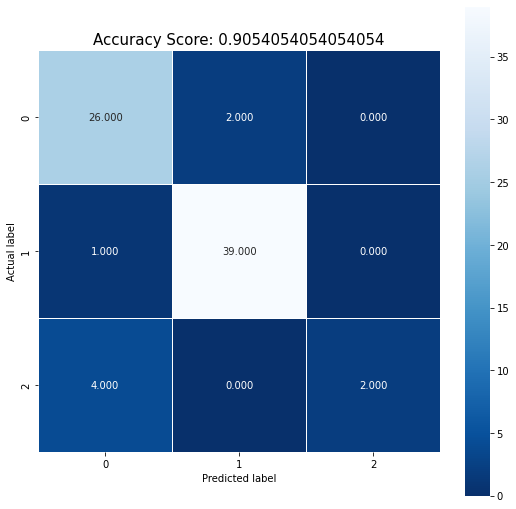

In [8]:
#matriz de confusão - Modelo de Regressão Logistica

plt.figure(figsize=(9,9))
sns.heatmap(matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);


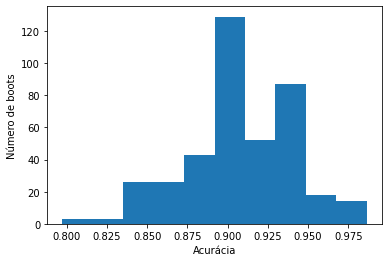

Intervalo de confiança : [0.8378378378378378,0.972972972972973]
Acurácia 'real' do modelo performada no teste : 0.9054054054054054


In [10]:
import random
import numpy as np
import plotly.express as px

# Intervalo de confiança da acurácia da regressão logística

# cria boot de acordo com as regras do artigo : 1- size_test= size_boot , 2- repetições permitidas
# Notar que, obiviamente, o cálculo da confiança da métrica acurácia usa o X_test

# BOOT COMO NUMPY.ARRAY AO INVES DE DATAFRAME - MELHROU MT

def new_boot(X_test, y_test):
  novo_X = X_test.copy()

  novo_Y = y_test.copy()

  c= 0
  while c < len(X_test):
    rand = random.randint(0,len(X_test)-1)
    novo_X[c] = X_test[rand].copy()
    novo_Y[c] = y_test[rand]
    c= c+1
  return novo_X , novo_Y

# Pega a acurácia de um boot
# Ajuste em pegar a mérica sem ser pelo report
def pegar_acuracia_do_relatorio(novo_X , novo_Y):
                     
  return accuracy_score(novo_Y, logistic_regression.predict(novo_X), sample_weight=None)

# calcula a distribuição dos boots
  
numero_boots = 401
lista_boots = []
contador = 0

while contador < numero_boots:
  x, y = new_boot(X_test, y_test)
  lista_boots.append(pegar_acuracia_do_relatorio(x, y))
  contador =contador +1

plt.hist(lista_boots) 
plt.xlabel('Acurácia')
plt.ylabel('Número de boots')
plt.show() 

#converte a lista em float explicitamente para a função percentile ser aplicada
array = list()
for elemento in lista_boots:
  array.append(float(elemento))

# calcula os limites da integral da gaussiana que correspondem a área desejada

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  np.percentile(array, p) 
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  np.percentile(array, p)

print("Intervalo de confiança : ["+str(lower)+","+str(upper)+"]")
print("Acurácia 'real' do modelo performada no teste : "+ str(accuracy_score(y_test, logistic_regression.predict(X_test), sample_weight=None)))


# Observação, de acordo com o teorema do limite central, quanto maior o número de boots, mais a distribuição gaussiana ficará melhor definida.


In [ ]:
#rede neural - Modelo
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold,ShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import classification_report

#4) Demanda-4- Implementar para cada modelo as regras anteriores

model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(64,64,64), max_iter = 100000, random_state=0) 
model_sem_treino = model
model.fit(X_train,y_train)

#matriz de confusão
y_pred=model.predict(X_test) 
matrix=confusion_matrix(y_test,y_pred)

#cross validation para obter a acurácia e a precisão , k =cv =10
#Cros_validação para acuracia e precisao
precisao = cross_validate(model, X_train,y_train,scoring='precision_weighted', cv=10)
acuracia = cross_validate(model, X_train, y_train, cv=10, scoring='accuracy')        

print("Acurácia = " + str(acuracia['test_score'].mean()))
print("Precisão = " + str(precisao['test_score'].mean()))

#print(classification_report(y_test,model.predict(X_test)))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Acurácia = 0.9418300653594771
Precisão = 0.9185642135642136


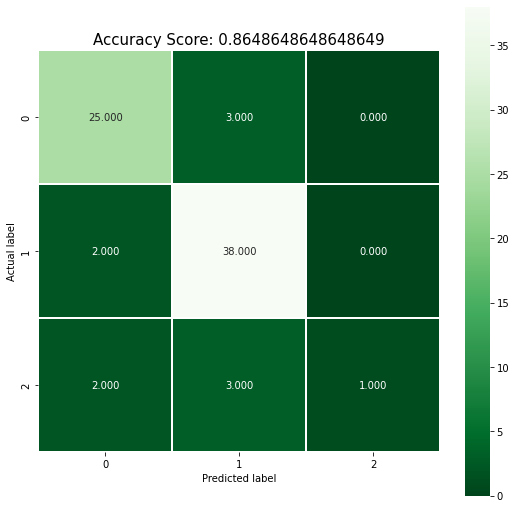

In [ ]:
#Matriz de Confusão da Rede Neural
plt.figure(figsize=(9,9))
sns.heatmap(matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Greens_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);

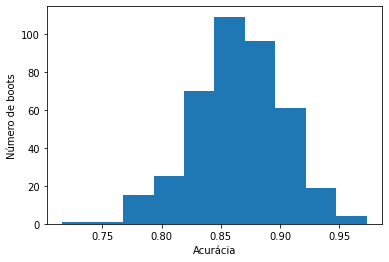

Intervalo de confiança : [0.7837837837837838,0.9324324324324325]
Acurácia 'real' do modelo performada no teste : 0.8648648648648649


In [ ]:
import random
import numpy as np
import plotly.express as px

# Intervalo de confiança da acurácia da rede neural

# cria boot de acordo com as regras do artigo : 1- size_test= size_boot , 2- repetições permitidas
# Notar que, obiviamente, o cálculo da confiança da métrica acurácia usa o X_test

# BOOT COMO NUMPY.ARRAY AO INVES DE DATAFRAME - MELHROU MUITO

def new_boot(X_test, y_test):
  novo_X = X_test.copy()

  novo_Y = y_test.copy()

  c= 0
  while c < len(X_test):
    rand = random.randint(0,len(X_test)-1)
    novo_X[c] = X_test[rand].copy()
    novo_Y[c] = y_test[rand]
    c= c+1
  
  return novo_X , novo_Y

# Pega a acurácia de um boot
# Ajuste em pegar a mérica sem ser pelo report
def pegar_acuracia_do_relatorio(novo_X , novo_Y):
                     
  return accuracy_score(novo_Y, model.predict(novo_X), sample_weight=None)

# calcula a distribuição dos boots  
numero_boots = 401
lista_boots = []
contador = 0

while contador < numero_boots:
  x, y = new_boot(X_test, y_test)
  lista_boots.append(pegar_acuracia_do_relatorio(x, y))
  contador =contador +1

plt.hist(lista_boots) 
plt.xlabel('Acurácia')
plt.ylabel('Número de boots')
plt.show() 

#converte a lista em float explicitamente para a função percentile ser aplicada
array = list()
for elemento in lista_boots:
  array.append(float(elemento))

# calcula os limites da integral da gaussiana que correspondem a área desejada

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  np.percentile(array, p) 
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  np.percentile(array, p)

print("Intervalo de confiança : ["+str(lower)+","+str(upper)+"]")
print("Acurácia 'real' do modelo performada no teste : "+ str(accuracy_score(y_test, model.predict(X_test), sample_weight=None)))

# Observação, de acordo com o teorema do limite central, quanto maior o número de boots, mais a distribuição gaussiana ficará melhor definida.

In [ ]:
#Floresta Randomica - Modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold,ShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

# ATENÇÃO: aqui os hyperparametros estao setados, por isso eu comentei o gridseaRCH, ECONOMIZANDO MUITO TEMPO
# Modelo mais preciso e com mais acuracia, justamente pelo fato de ter tido os hyperparametros
modelRF = RandomForestClassifier(bootstrap = False, max_depth = 20, 
                                    max_features = 'auto', min_samples_leaf = 3,
                                    min_samples_split = 2, n_estimators = 200)

modelRF_sem_treino = modelRF
modelRF.fit(X_train,y_train)

#matriz de confusão
y_pred=modelRF.predict(X_test)
matrix =confusion_matrix(y_test,y_pred)

#cross validation para obter a acurácia e a precisão , k =cv =10
#Cros_validação para acuracia e precisao
precisao = cross_validate(modelRF, X_train,y_train,scoring='precision_weighted', cv=10)
acuracia = cross_validate(modelRF, X_train, y_train, cv=10, scoring='accuracy')
        
print("Acurácia = " + str(acuracia['test_score'].mean()))
print("Precisão = " + str(precisao['test_score'].mean()))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Acurácia = 0.8196078431372549
Precisão = 0.7601519830931596


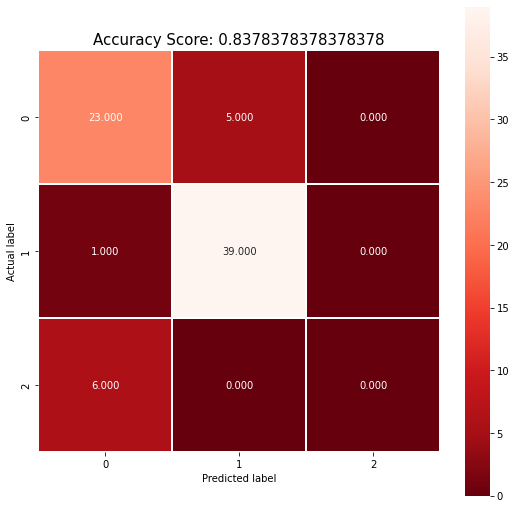

In [ ]:
#Matriz de Confusão da Rede Neural
plt.figure(figsize=(9,9))
sns.heatmap(matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);

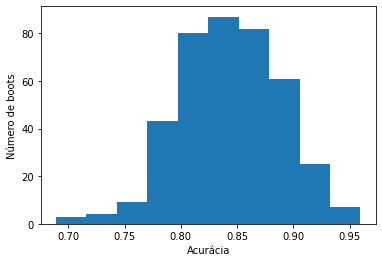

Intervalo de confiança : [0.7432432432432433,0.918918918918919]
Acurácia 'real' do modelo performada no teste : 0.8378378378378378


In [ ]:
# Intervalo de confiança da acurácia da regressão logística
import random
import numpy as np
import plotly.express as px

# cria boot de acordo com as regras do artigo : 1- size_test= size_boot , 2- repetições permitidas
# Notar que, obiviamente, o cálculo da confiança da métrica acurácia usa o X_test

# BOOT COMO NUMPY.ARRAY AO INVES DE DATAFRAME - MELHROU MT

def new_boot(X_test, y_test):
  novo_X = X_test.copy()

  novo_Y = y_test.copy()

  c= 0
  while c < len(X_test):
    rand = random.randint(0,len(X_test)-1)
    novo_X[c] = X_test[rand].copy()
    novo_Y[c] = y_test[rand]

    c= c+1
  

  return novo_X , novo_Y

# Pega a acurácia de um boot
# Ajuste em pegar a mérica sem ser pelo report
def pegar_acuracia_do_relatorio(novo_X , novo_Y):
                     
  return accuracy_score(novo_Y, modelRF.predict(novo_X), sample_weight=None)

# calcula a distribuição dos boots
  
numero_boots = 401
lista_boots = []
contador = 0

while contador < numero_boots:
  x, y = new_boot(X_test, y_test)
  lista_boots.append(pegar_acuracia_do_relatorio(x, y))
  contador =contador +1

plt.hist(lista_boots) 
plt.xlabel('Acurácia')
plt.ylabel('Número de boots')
plt.show() 

#converte a lista em float explicitamente para a função percentile ser aplicada
array = list()
for elemento in lista_boots:
  array.append(float(elemento))

# calcula os limites da integral da gaussiana que correspondem a área desejada
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  np.percentile(array, p) 
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  np.percentile(array, p)

print("Intervalo de confiança : ["+str(lower)+","+str(upper)+"]")
print("Acurácia 'real' do modelo performada no teste : "+ str(accuracy_score(y_test, modelRF.predict(X_test), sample_weight=None)))

# Observação, de acordo com o teorema do limite central, quanto maior o número de boots, mais a distribuição gaussiana ficará melhor definida.

**O teste t-paired** realizado para **comparação** entre os modelos de **Regressão Logística, Rede Neural e Floresta Randômica** apresentou resultados que sugerem que a **Floresta Randômica é o melhor modelo**, pois o resultado do teste t foi significante (p < 0.05) e indicou que a diferença entre a performance deste modelo e as outras duas é estatisticamente significativa.

In [ ]:
# ttest - Regressão e Rede neural
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1=logistic_regression_sem_treino,estimator2=model_sem_treino,X=previsores, y=classe)
alpha = 0.05

print('t statistic: %.3f' % t)
print('aplha ', alpha)
print('p value: %.3f' % p)

if p > alpha:
  print("Fail to reject null hypotesis")
else:
  print("Reject null hypotesis")

t statistic: 0.324
aplha  0.05
p value: 0.759
Fail to reject null hypotesis


In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv

# ttest - Regressão e Floresta randomica

t, p = paired_ttest_5x2cv(estimator1=logistic_regression_sem_treino,estimator2=modelRF_sem_treino,X=previsores, y=classe)
alpha = 0.05

print('t statistic: %.3f' % t)
print('aplha ', alpha)
print('p value: %.3f' % p)

if p > alpha:
  print("Fail to reject null hypotesis")
else:
  print("Reject null hypotesis")

t statistic: -5.363
aplha  0.05
p value: 0.003
Reject null hypotesis


In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv

# ttest - Rede Neural e Floresta randomica

t, p = paired_ttest_5x2cv(estimator1=model_sem_treino,estimator2=modelRF_sem_treino,X=previsores, y=classe)
alpha = 0.05

print('t statistic: %.3f' % t)
print('aplha ', alpha)
print('p value: %.3f' % p)

if p > alpha:
  print("Fail to reject null hypotesis")
else:
  print("Reject null hypotesis")

t statistic: -2.242
aplha  0.05
p value: 0.075
Fail to reject null hypotesis
